In [2]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.classifyingEdges.classifyingFLANT5 import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingDeBerta import classify_link_pairs_zero_shot, classify_link_pairs_zero_shot_two_step
#from Stage2.classifyingEdges.classifyingOpenAI import classify_link_pairs_openAI
from Stage2.classifyingEdges.metrics import metrics
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

### Step 1. ###
Load the model and download the website

In [3]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
# url = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://westinghousenuclear.com/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


### Step 2. ###
Apply the graph model to extract all the possible edges.
This extracts all text nodes found and outputs all possible edges, along with their probabilities

In [4]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

/vol/bitbucket/mjh24/IAEA-thesis/Stage2/txtGraphExtraction/extract_mini_txt_graphs_helper.py:141: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


In [5]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, "%'\\s", lower=False), normalise_text(b, "%'\\s", lower=False)])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)
alltxtnodes, alltxtnodes_idx = np.unique(sorted_label_index, return_index=True)
alltxtnodes_idx = np.array([[int(idx/2),0] if idx%2==0 else [int(idx/2),1] for idx in alltxtnodes_idx])
# print(alltxtnodes, sorted_label_index[alltxtnodes_idx[:,0],alltxtnodes_idx[:,1]])

### Step 3. ###
This filters out all the nodes where the text is a button/navigational link.

This uses a FLAN-T5 model

In [6]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isInstruction, instructionalTxt = clean_instructional_text(txtsShortened, batch_size=32)
opmask = np.array(isInstruction, dtype=bool)
mask = np.logical_not(opmask)

print("All the nodes filtered out:\n\n")
for key, value in instructionalTxt.items():
    if value == 1:
        print(key)

All the nodes filtered out:


Learn More
Product Spotlights
Join Our Team
Explore Now
Learn more about why Databricks selected Westinghouse AI for its 2025 Data Intelligence in Energy Utility Award
Blog
Learn More Watch Video
Read More
WestinghouseNavigator
Explore Careers
Learn more about how Westinghouse enhances training staffing and outsourcing with options that benefit your plants bottom line
Explore
Explore our interactive 3D visualization tool for innovative answers to operating plant challenges
Access our custom technology library designed for nuclear engineering students and professionals
Take a Look


In [7]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

### Step 5. ###
This filters out all the low probability edges using the finding from the probability paper. At least one edge per node is saved

In [8]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

1190  ->  68


### Step 6. ###
This filters out all the edges where the two text nodes make no sense together (i.e. they talk about different things)

In [9]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=64)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1]


In [10]:
#Quick informal test
# y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
# #classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
# y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [11]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
#metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

In [12]:
# if len(classificationFlan) != len(txts):
#     raise Exception("The classification is not the same length as the number of edges")
# for (pair, lab) in zip(txts, classificationFlan):
#         print(lab, pair)

#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

In [13]:
mask = np.array([(False if i==3 else True) for i in classificationFlan])
print("Removing the following nodes:\n\n", txts[~mask])
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

Removing the following nodes:

 [['Westinghouse Joins Texas Nuclear Alliance as a Founding Member'
  'Westinghouse AP1000 Design Receives US Licensing Extension to 2046']
 ['Westinghouse AP1000 Design Receives US Licensing Extension to 2046'
  'Westinghouse Joins Texas Nuclear Alliance as a Founding Member']
 ['Shape Your Future' 'Manufacturing Operations Maintenance']
 ['Manufacturing Operations Maintenance' 'Shape Your Future']
 ['Shape Your Future' 'eVinci Microreactor']]


### Final edge output ###
Here are the results after all the filtering

['AP300 SMR'
 'The AP300 SMR is the next evolution of the licensed AP1000 technology']
['The AP300 SMR is the next evolution of the licensed AP1000 technology'
 'AP300 SMR']
['eVinci Microreactor'
 'The next generation small modular reactor for remote applications']
['The next generation small modular reactor for remote applications'
 'eVinci Microreactor']
['Enhance your training staffing and outsourcing needs with our training and resource solutions'
 'WestinghouseIQ']
['WestinghouseIQ'
 'Enhance your training staffing and outsourcing needs with our training and resource solutions']
['AP1000 PWR'
 "The world's first proven Generation III pressurized water reactor and passive safety plant available"]
["The world's first proven Generation III pressurized water reactor and passive safety plant available"
 'AP1000 PWR']
['When it comes to creating a more sustainable planet the need for renewable energy cant replace the need for safe energy With nuclear power you get the best of both worl

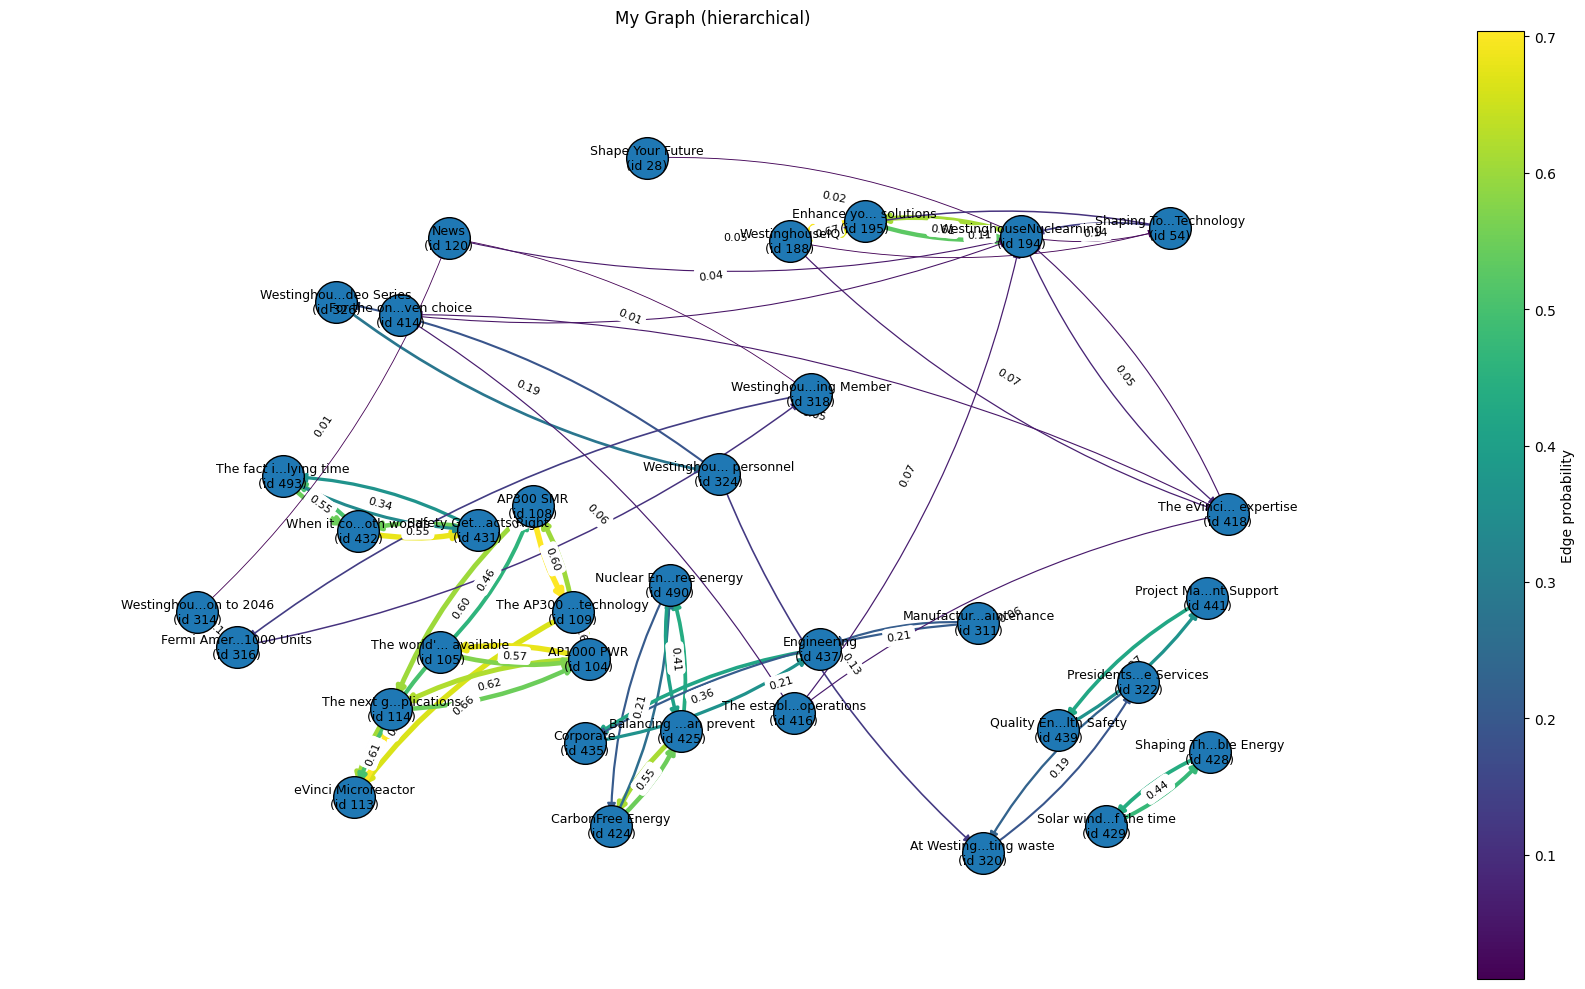

{'G': <networkx.classes.digraph.DiGraph at 0x758f384ebef0>,
 'pos': {108: array([-0.27182383,  0.11952766]),
  109: array([-0.20905806, -0.14829485]),
  113: array([-0.55135992, -0.616592  ]),
  114: array([-0.49347032, -0.39516373]),
  195: array([0.24897035, 0.83966701]),
  188: array([0.13168718, 0.79015109]),
  104: array([-0.18421409, -0.2673354 ]),
  105: array([-0.41693036, -0.24891969]),
  432: array([-0.54572781,  0.05556282]),
  431: array([-0.35806933,  0.05927564]),
  425: array([-0.03843304, -0.45101018]),
  424: array([-0.14882937, -0.68956336]),
  194: array([0.49484795, 0.80159741]),
  493: array([-0.66403708,  0.19417182]),
  429: array([ 0.62770616, -0.69115859]),
  428: array([ 0.79037167, -0.5025428 ]),
  490: array([-0.05713754, -0.07988208]),
  441: array([ 0.78612008, -0.11312967]),
  439: array([ 0.55255596, -0.44822842]),
  437: array([ 0.17869402, -0.2426329 ]),
  435: array([-0.18982106, -0.48008257]),
  326: array([-0.57999502,  0.63626173]),
  324: array([0

In [14]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(txts, "presidents kaizen", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)